In [ ]:
import os
from os import path
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage import filters
from skimage import io
import numpy as np

In [ ]:
drive_mount_dir = '/gdrive'
root_dir = '/gdrive/My Drive/diploma'
data_dir = 'raw_data'
data_root = path.join(root_dir, data_dir)

In [ ]:
from google.colab import drive
drive.mount(drive_mount_dir)

Mounted at /gdrive


### Предварительная обработка файлов

На данном этапе происходит группирование данных по именам файлов.

Имя файла имеет структуру:

**длина волны_камера_метка времени**

На выходе получаем словарь с ключом (длина волны, метка времени)
Каждый элемент словаря - словарь с двумя значениями:
 - c - цветное изображение
 - g - черно-белое изображение

In [ ]:
# группируем изображения по длине волны и метке времени
img_groups = {}

CAMERA_RGB = 'acA1920-50gc'
CAMERA_GRAY = 'acA1920-40um'

raw_images_list = os.listdir(data_root)
for img_name in tqdm(raw_images_list, 'reading images'):
  wave_len, camera, timestamp = img_name.split('_')
  timestamp = timestamp.split('.')[0] # remove .jpg extension

  full_img_path = path.join(data_root, img_name)
  img = None

  if (wave_len, timestamp) not in img_groups:
    img_groups[(wave_len, timestamp)] = {}

  if camera == CAMERA_RGB:
    img = io.imread(full_img_path)
    img_groups[(wave_len, timestamp)]['c'] = img
  elif camera == CAMERA_GRAY:
    img = io.imread(full_img_path)
    img_groups[(wave_len, timestamp)]['g'] = img
  else:
    print('IMG: {} uknown camera'.format(img_name))
    continue

Сравним пару изображений (цвет -> чб, чб)

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


[]

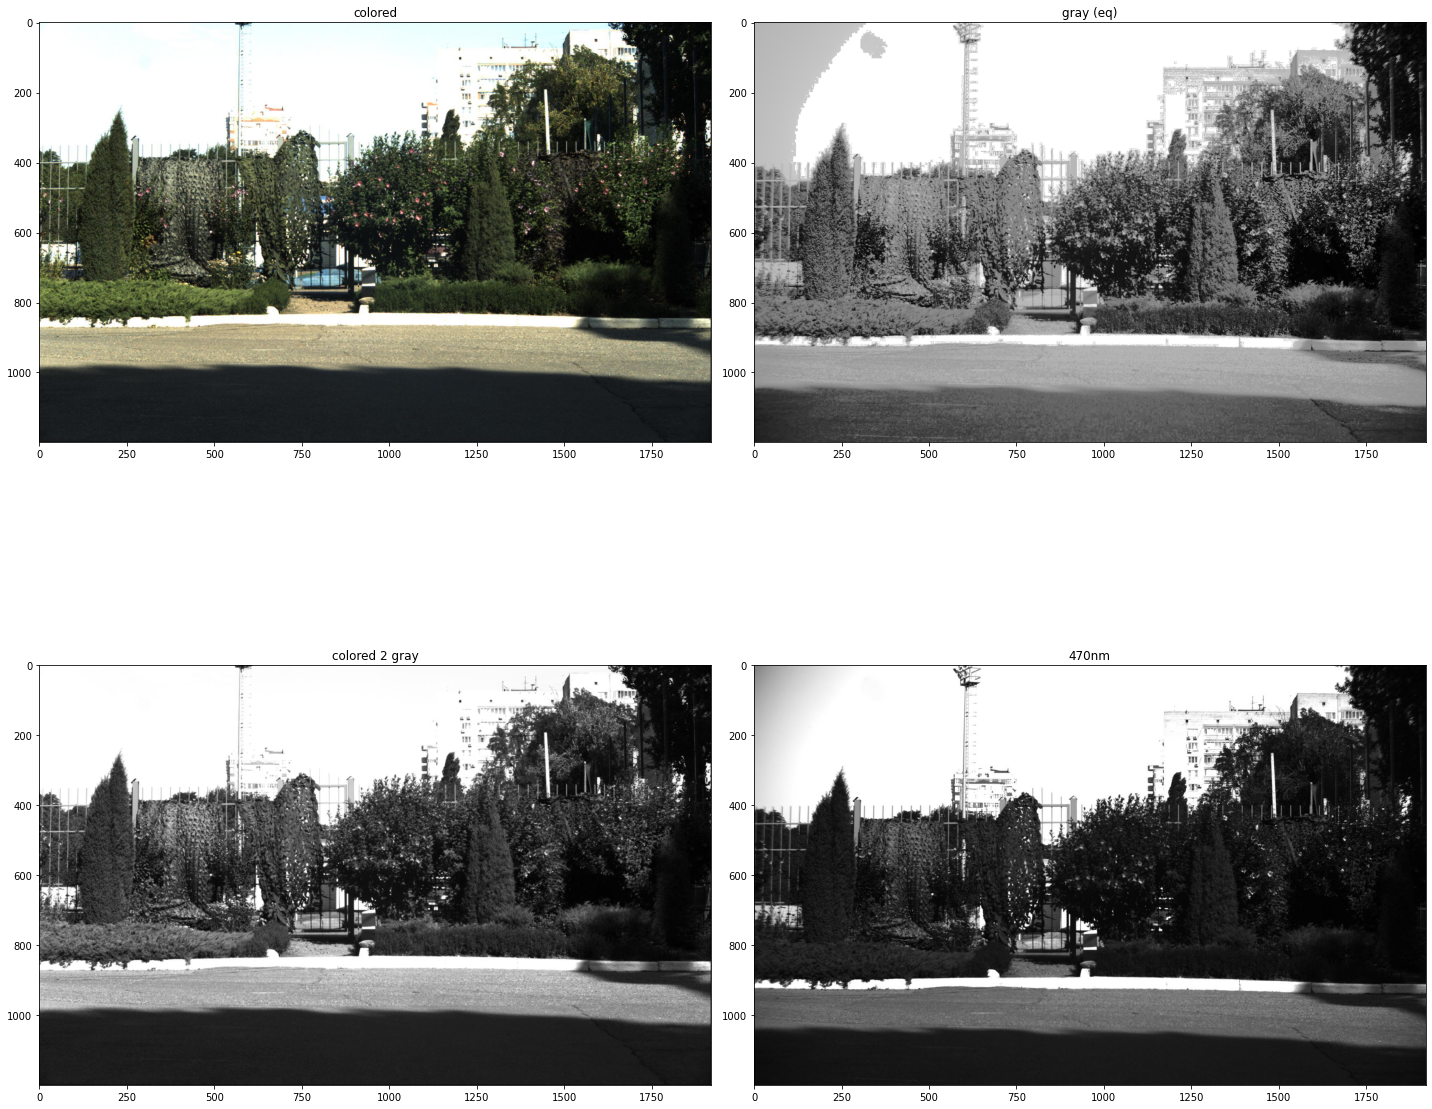

In [ ]:
from skimage.color import rgb2gray
from skimage import data, transform, exposure
from skimage.util import compare_images

img_group = img_groups[('470', '1595683798')]
src_c = img_group['c']
src_g = img_group['g']
src_c_gray = rgb2gray(src_c)

src_g_equalized = exposure.equalize_hist(src_g)

f, axarr = plt.subplots(2, 2, figsize = (20,20))
axarr[0, 0].set_title('colored')
axarr[0, 0].imshow(src_c)

axarr[0, 1].set_title('gray (eq)')
axarr[0, 1].imshow(src_g_equalized)

axarr[1, 1].set_title('470nm')
axarr[1, 1].imshow(src_g)

axarr[1, 0].set_title('colored 2 gray')
axarr[1, 0].imshow(src_c_gray, cmap=plt.cm.gray)

plt.tight_layout()
plt.plot()

In [ ]:
diff_src_g = compare_images(src_g[:,:,0], src_c_gray, method='diff')

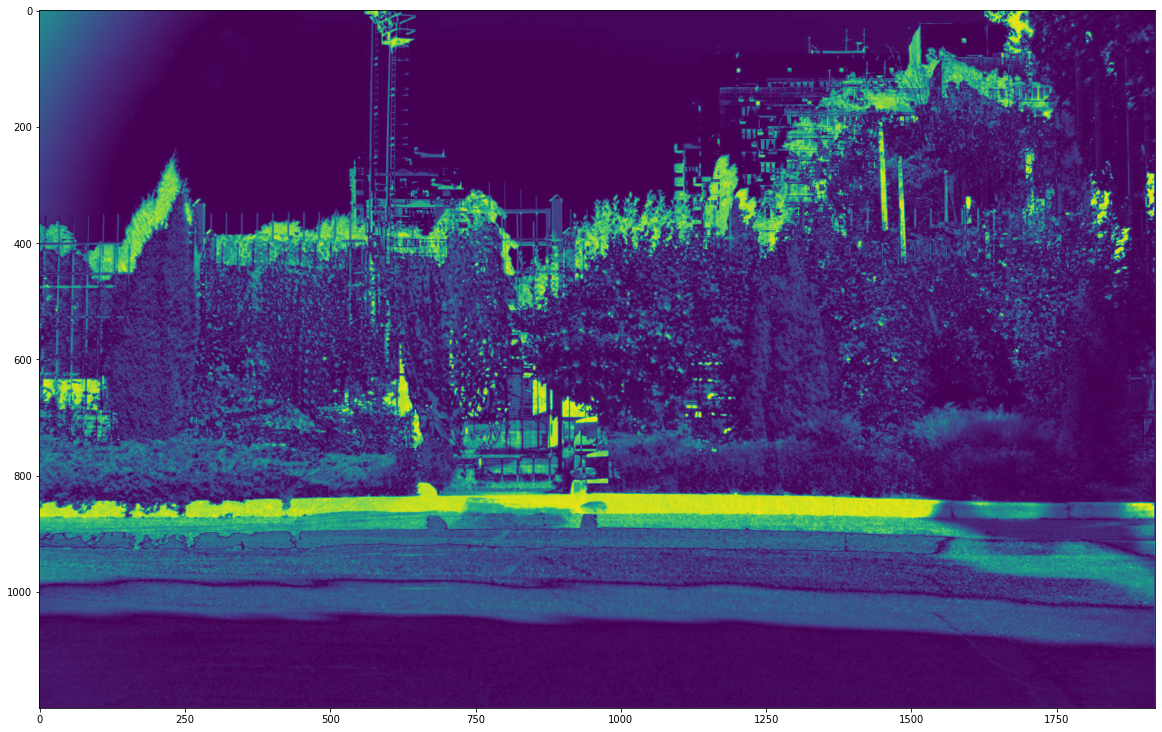

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(diff_src_g)

Как можно видеть, в изображениях наблюдается сдвиг.

Попробуем обнаружить величину сдвига и сопоставить изображения так, чтобы они максимально совпадали

In [ ]:
from skimage.feature import register_translation

img1 = src_g[:,:,0]
img2 = src_c_gray

detected_shift = register_translation(img1, img2)
detected_shift

(array([55., 20.]), 0.4299115092263263, -2.7144720967566665e-18)

На первой паре сдвиг составляет (55, 20)

Проверим другие пары

In [ ]:
from skimage.feature import register_translation
from skimage.color import rgb2gray

shifts = {}

for (key, pair) in tqdm(img_groups.items()):
  img1 = pair['g'][:,:,0]
  img2 = rgb2gray(pair['c'])

  (detected_shift, err, phase_diff) = register_translation(img1, img2)
  shifts[key] = detected_shift

In [ ]:
shifts

{('470', '1595682323'): array([56., 10.]),
 ('470', '1595682325'): array([56., 12.]),
 ('470', '1595682327'): array([56., 11.]),
 ('470', '1595682639'): array([52., 13.]),
 ('470', '1595682641'): array([51., 14.]),
 ('470', '1595682643'): array([50., 13.]),
 ('470', '1595682822'): array([61., 18.]),
 ('470', '1595682824'): array([61., 17.]),
 ('470', '1595682826'): array([61., 17.]),
 ('470', '1595683056'): array([58., 17.]),
 ('470', '1595683058'): array([58., 17.]),
 ('470', '1595683060'): array([58., 17.]),
 ('470', '1595683289'): array([57., 18.]),
 ('470', '1595683291'): array([57., 17.]),
 ('470', '1595683292'): array([57., 18.]),
 ('470', '1595683535'): array([61., 19.]),
 ('470', '1595683537'): array([61., 19.]),
 ('470', '1595683540'): array([61., 19.]),
 ('470', '1595683798'): array([55., 20.]),
 ('470', '1595683800'): array([55., 20.]),
 ('470', '1595683802'): array([55., 19.]),
 ('540', '1595682432'): array([56., 11.]),
 ('540', '1595682434'): array([57., 11.]),
 ('540', '1

In [ ]:
# filter too big values
shifts_np = np.array(list(shifts.values()))
shifts_np.mean(axis=0)

array([ 44.79245283, 131.91509434])

In [ ]:
upper_bound = 100 # отсекаем слишком большие значения (т.е. аномалии)

mean_shift = np.array([row for row in shifts_np if np.all(abs(row) < upper_bound)]).mean(axis=0)
mean_shift

array([57, 16])

In [ ]:
mean_mask = np.repeat(mean_shift[np.newaxis,:], shifts_np.shape[0], axis=0)
result_shift = np.where(abs(shifts_np) > upper_bound, mean_mask, shifts_np).astype(int)

In [ ]:
result_shift

array([[56, 10],
       [56, 12],
       [56, 11],
       [56, 11],
       [57, 11],
       [56, 11],
       [54, 11],
       [54, 10],
       [53, 12],
       [60, 11],
       [59, 11],
       [60, 11],
       [57, 16],
       [57, 16],
       [57, 16],
       [52, 13],
       [51, 14],
       [50, 13],
       [59, 16],
       [59, 15],
       [59, 15],
       [58, 14],
       [58, 14],
       [58, 14],
       [57, 16],
       [57, 16],
       [57, 16],
       [57, 16],
       [57, 16],
       [57, 16],
       [61, 18],
       [61, 17],
       [61, 17],
       [57, 17],
       [57, 17],
       [56, 17],
       [60, 18],
       [60, 17],
       [59, 18],
       [57,  0],
       [57,  0],
       [57,  0],
       [57, 16],
       [57, 16],
       [57, 16],
       [58, 17],
       [58, 17],
       [58, 17],
       [61, 17],
       [61, 17],
       [61, 17],
       [55, 17],
       [55, 17],
       [55, 18],
       [57, 16],
       [57, 16],
       [57, 16],
       [57, 16],
       [57, 16

In [ ]:
shifted_images = {}

for (idx, (k, pair)) in tqdm(enumerate(img_groups.items())):
  shift = result_shift[idx]

  if shift[0] == 0 and shift[1] == 0:
    img_g = pair['g']
    img_c = pair['c']
  elif shift[0] == 0:
    img_g = pair['g'][:,shift[1]:,:]
    img_c = pair['c'][:,:-shift[1],:]
  elif shift[1] == 0:
    img_g = pair['g'][shift[0]:,shift[1]:,:]
    img_c = pair['c'][:-shift[0],:,:]
  else:
    img_g = pair['g'][shift[0]:,shift[1]:,:]
    img_c = pair['c'][shift[0]:,shift[1]:,:]

  shifted_images[k] = {
      'g': img_g,
      'c': img_c
  }

для каждой пары считаем разницу между цвет -> чб и мультиспектром после сдвига

In [ ]:
diff_images_path = path.join(root_dir, 'diff_images')

if not path.exists(diff_images_path):
  os.mkdir(diff_images_path)

for (key, img_pair) in tqdm(shifted_images.items(), 'computing diff images'):
  grp_img_c = img_pair['c']
  grp_img_g = img_pair['g']

  grp_img_c_gray = rgb2gray(grp_img_c)

  # print(key, grp_img_g[:,:,0].shape, grp_img_c_gray.shape)

  diff_grp_comp = compare_images(grp_img_g[:,:,0], grp_img_c_gray, method='diff')
  #plt.figure(figsize=(20, 20))
  plt.imsave(path.join(diff_images_path, '{}_{}.png').format(key[0], key[1]), diff_grp_comp)

In [ ]:
group1 = list(shifted_images.values())[0]

gr1_img_c = group1['c']
gr1_img_g = group1['g']

gr1_img_c_gray = rgb2gray(gr1_img_c)

In [ ]:
gr1_img_c.shape

(1143, 1920, 3)

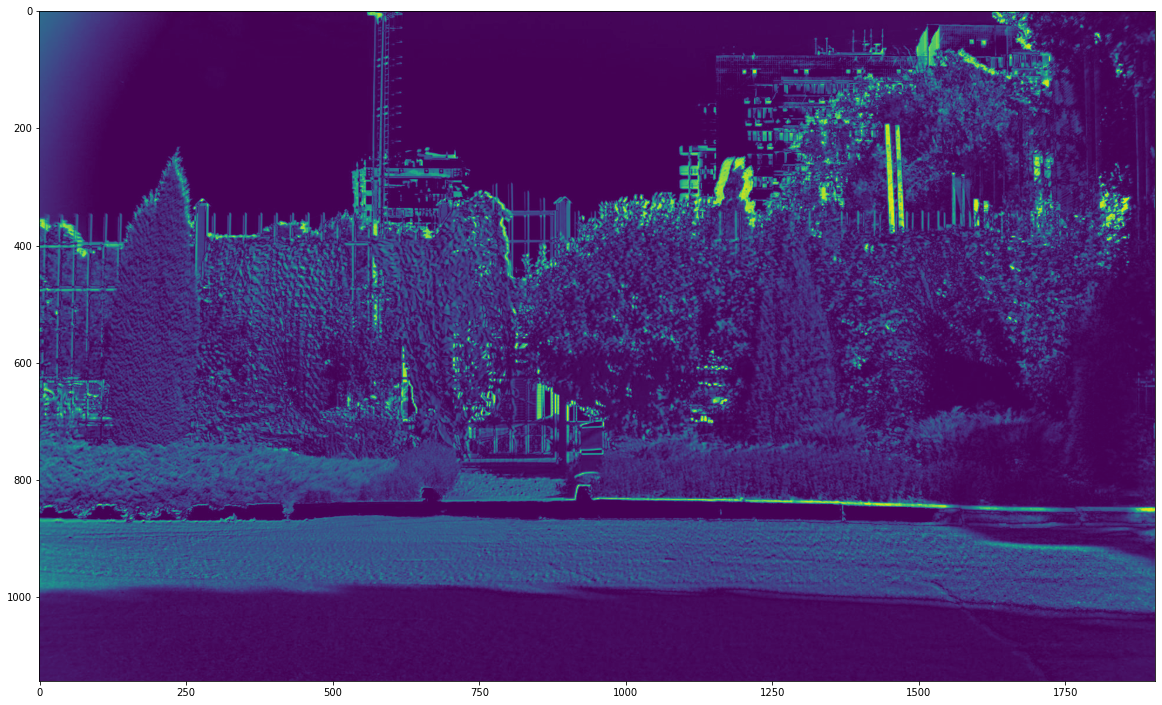

In [ ]:
diff_gr_1_comp = compare_images(gr1_img_g[:,:,0], gr1_img_c_gray, method='diff')

plt.figure(figsize = (20,20))
plt.imshow(diff_gr_1_comp)